In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.decomposition import PCA

In [2]:
# Import dataset 
songs = pd.read_csv('genre_music.csv')

# EDA
songs.info()
songs.head()

# Calculate class proportions
prop_popularity = sum(songs.popularity)/len(songs.popularity)
print(f'Proportion of Popular Songs in Train Data: {prop_popularity: 5f}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41099 entries, 0 to 41098
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track             41099 non-null  object 
 1   artist            41099 non-null  object 
 2   danceability      41099 non-null  float64
 3   energy            41099 non-null  float64
 4   key               41099 non-null  int64  
 5   loudness          41099 non-null  float64
 6   mode              41099 non-null  int64  
 7   speechiness       41099 non-null  float64
 8   acousticness      41099 non-null  float64
 9   instrumentalness  41099 non-null  float64
 10  liveness          41099 non-null  float64
 11  valence           41099 non-null  float64
 12  tempo             41099 non-null  float64
 13  duration_s        41099 non-null  float64
 14  time_signature    41099 non-null  int64  
 15  chorus_hit        41099 non-null  float64
 16  sections          41099 non-null  int64 

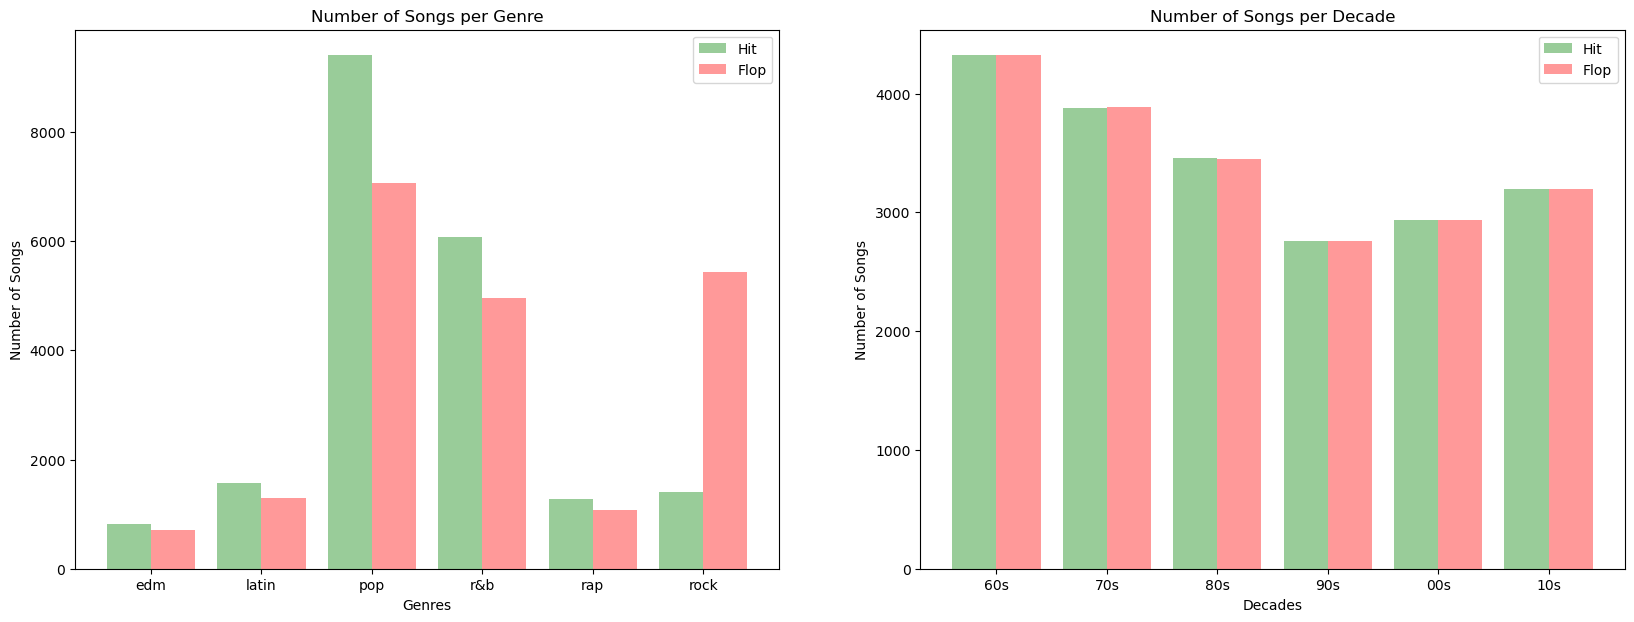

genre,edm,latin,pop,r&b,rap,rock
decade,,,,,,
60s,0.04,0.04,0.75,0.03,0.01,0.14
70s,0.03,0.05,0.53,0.28,0.02,0.10
80s,0.03,0.07,0.32,0.52,0.01,0.05
90s,0.05,0.07,0.20,0.55,0.09,0.03
00s,0.05,0.14,0.31,0.33,0.14,0.03
10s,0.04,0.11,0.48,0.18,0.15,0.03


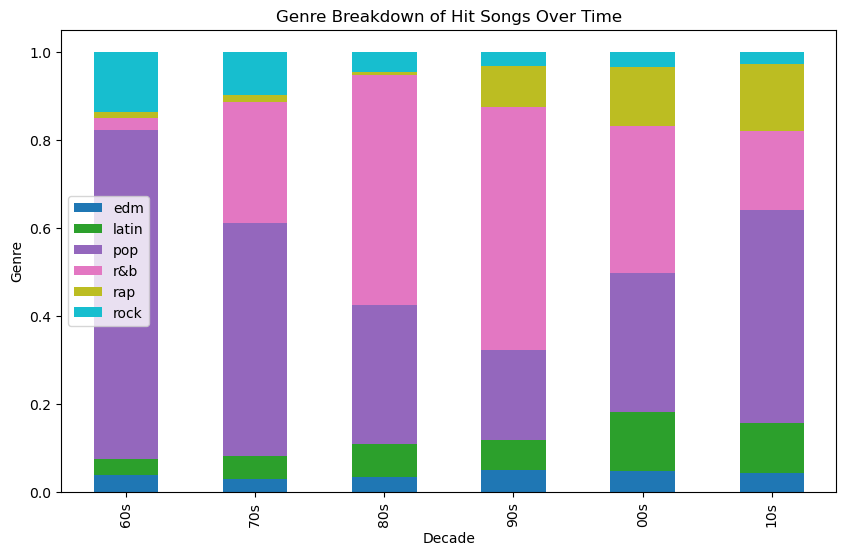

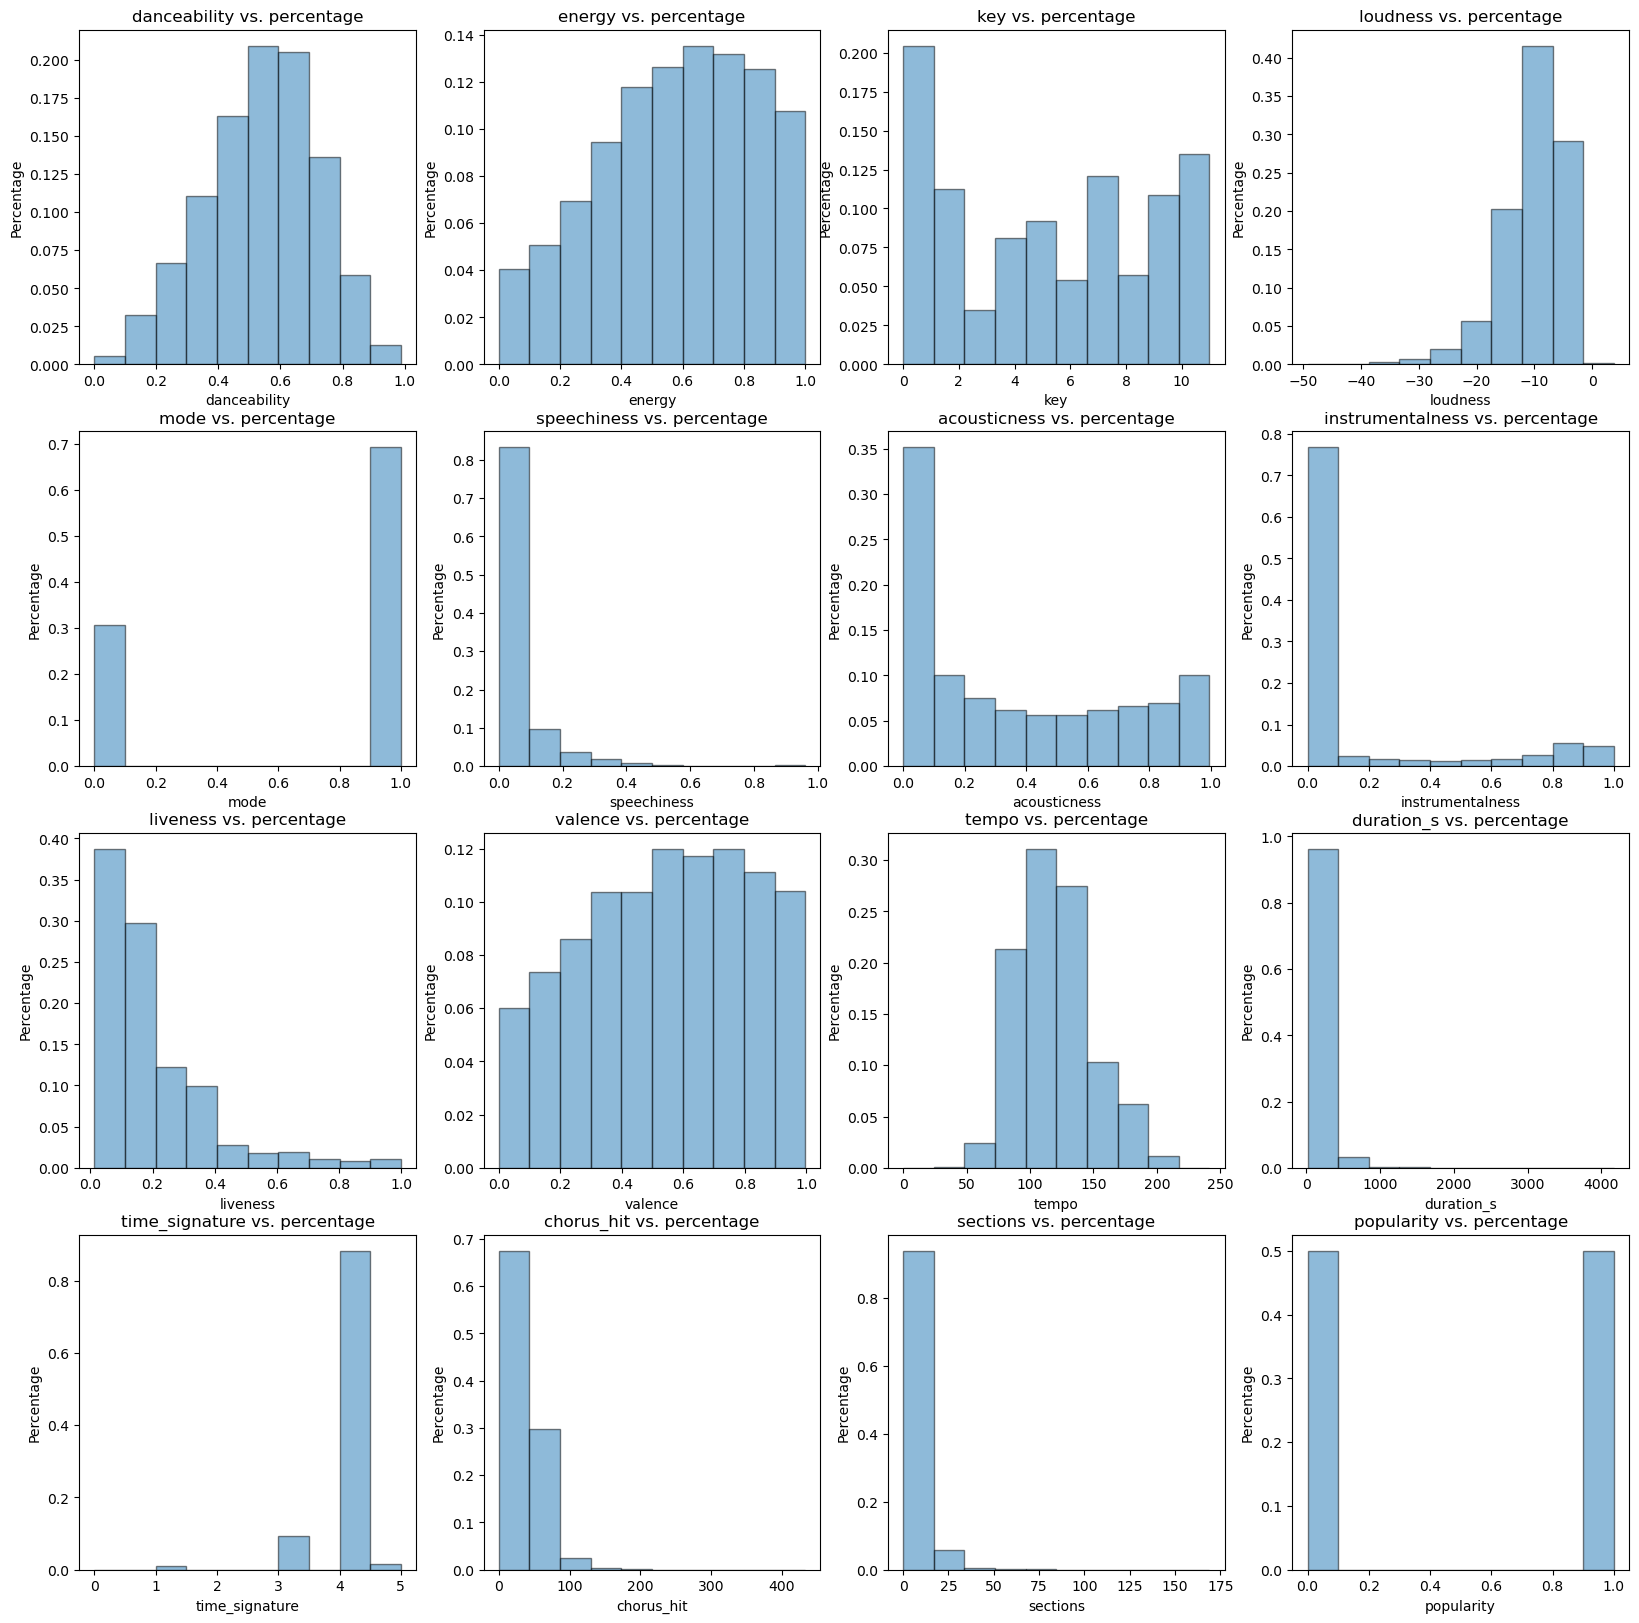

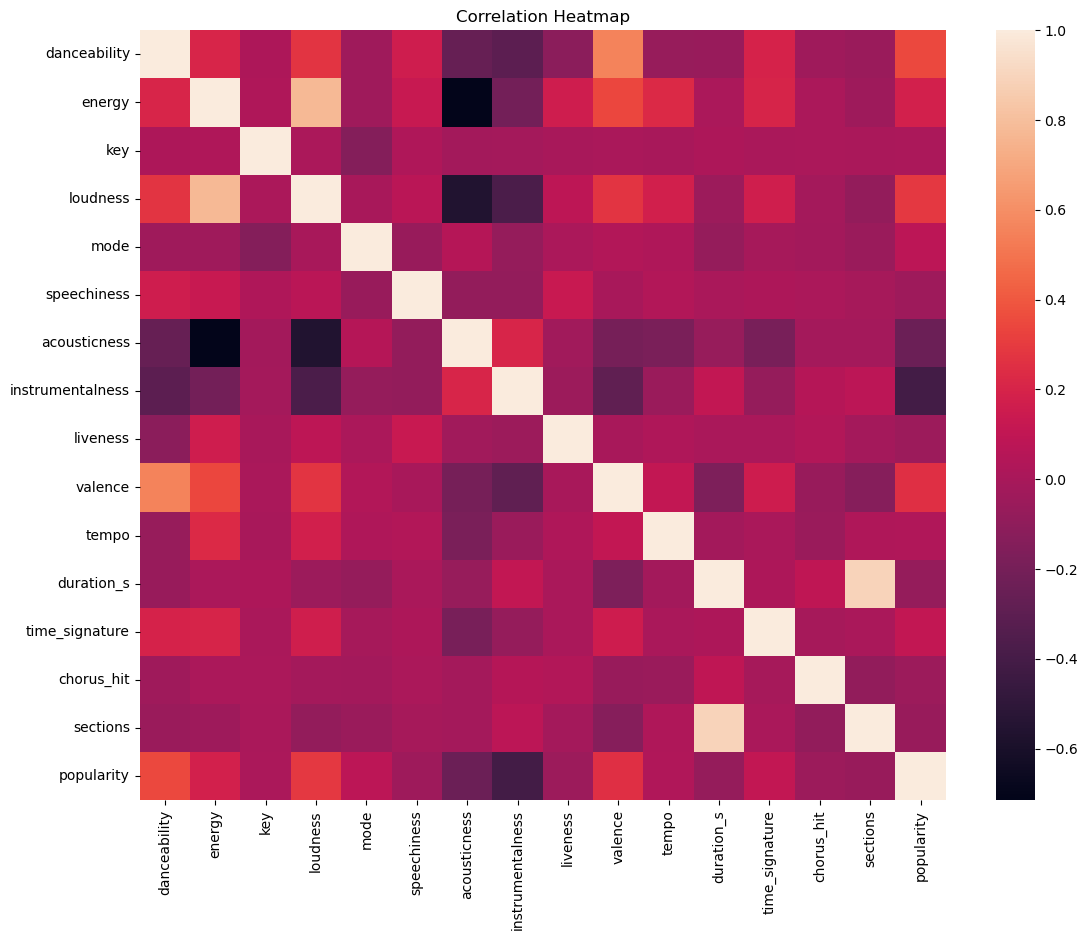

In [3]:
# Visualization for additional EDA
fig, ax = plt.subplots(1, 2, figsize = (20, 7))

# Genre vs Popularity bar graph
genres = sorted(songs['genre'].unique())
genre_hit = [len(songs[(songs['popularity']==1) & (songs['genre']==g)]) for g in genres]
genre_flop = [len(songs[(songs['popularity']==0) & (songs['genre']==g)]) for g in genres]

X_axis = np.arange(len(genres))
ax[0].bar(X_axis - 0.2, genre_hit, 0.4, label = 'Hit', color='g', alpha=0.4)
ax[0].bar(X_axis + 0.2, genre_flop, 0.4, label = 'Flop', color = 'r', alpha=0.4)
ax[0].set_xticks(X_axis, genres)
ax[0].set_xlabel("Genres")
ax[0].set_ylabel("Number of Songs")
ax[0].set_title("Number of Songs per Genre")
ax[0].legend()

# Decade vs Popularity bar graph
decades = (songs['decade'].unique())
decade_hit = [len(songs[(songs['popularity']==1) & (songs['decade']==d)]) for d in decades]
decade_flop = [len(songs[(songs['popularity']==0) & (songs['decade']==d)]) for d in decades]

X_axis = np.arange(len(decades))
ax[1].bar(X_axis - 0.2, decade_hit, 0.4, label = 'Hit', color='g', alpha=0.4)
ax[1].bar(X_axis + 0.2, decade_flop, 0.4, label = 'Flop', color='r', alpha=0.4)
ax[1].set_xticks(X_axis, decades)
ax[1].set_xlabel("Decades")
ax[1].set_ylabel("Number of Songs")
ax[1].set_title("Number of Songs per Decade")
ax[1].legend()

plt.show()

# Genre breakdown of hit songs over time
over_time = songs.loc[songs['popularity'] == 1]
over_time = over_time[['decade','genre']]
over_time_prop = pd.crosstab(index=over_time['decade'],
                             columns=over_time['genre'],
                             normalize="index")
index_order = ['60s','70s','80s','90s','00s','10s']
over_time_prop = over_time_prop.reindex(index_order)
over_time_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))

plt.title("Genre Breakdown of Hit Songs Over Time")
plt.legend()
plt.xlabel("Decade")
plt.ylabel("Genre")
# round the values in all columns to two decimal places
over_time_prop = over_time_prop.apply(lambda x: x.round(2))
display(over_time_prop)
plt.show()

# More visualization
fig, ax = plt.subplots(4, 4, figsize = (20, 20))

cols = 4
r, c = 0, 0

# Plot each predictor vs. popularity to examine potential relationships
for cname, t in zip(songs.columns, songs.dtypes):
    if t != object:
        ax[r, c].hist(songs[cname], weights=np.ones(len(songs)) / len(songs), alpha=0.5, ec='black')
        ax[r, c].set_title('%s vs. percentage' % cname)
        ax[r, c].set_xlabel(cname)
        ax[r, c].set_ylabel('Percentage')
        
        c += 1
        if c >= cols:
            r, c = r+1, 0
plt.show()

# Heat map for predictor-response correlation
quantitative = [col for col in songs.columns if col not in songs.select_dtypes('object').columns.to_list()]
correlation = songs[quantitative].corr()
fig, ax = plt.subplots(figsize=(13,10))
plt.title('Correlation Heatmap')
sns.heatmap(correlation)
plt.show()

In [4]:
# Prepare X, y
X, y = songs.drop(['track', 'artist', 'popularity'], axis=1), songs['popularity']

# Convert 'decade', 'genre' into categorical variables
X.decade = X.decade.astype('category')
X.genre = X.genre.astype('category')

# Create a label encoder object to encode the "decade" variable
label_encoder = LabelEncoder()

# Create a one-hot encoder object to encode the "genre" variable
one_hot_encoder = OneHotEncoder()

# Get the columns that contain categorical variables
categorical_columns = X.select_dtypes(include=['category']).columns

# Encode the categorical variables in the original dataframe
for col in categorical_columns:
    if col == "decade":
        # Encode the "decade" variable using label encoding
        X[col] = label_encoder.fit_transform(X[col])
        
    elif col == "genre":
        # Encode the "genre" variable using one-hot encoding and save the encoded values in a new array
        one_hot_encoded = one_hot_encoder.fit_transform(X[col].values.reshape(-1, 1)).toarray()
        
        # Create new columns for each unique category in the "genre" variable
        for i, category in enumerate(one_hot_encoder.categories_[0]):
            X[category] = one_hot_encoded[:, i]
            
        # Drop the original "genre" column
        X.drop(columns=["genre"], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=109)

# We will only be using the quantitative predictors for our models and use the categorical variables 'genre' and 'decade'
# for stratification purposes when exploring results and conclusions
quant_preds = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_s', 'time_signature', 'chorus_hit', 'sections']

# Initialize and fit a scaler
scaler = StandardScaler().fit(X_train[quant_preds])

# Transform train and test data
X_train[quant_preds] = scaler.transform(X_train[quant_preds])
X_test[quant_preds] = scaler.transform(X_test[quant_preds])

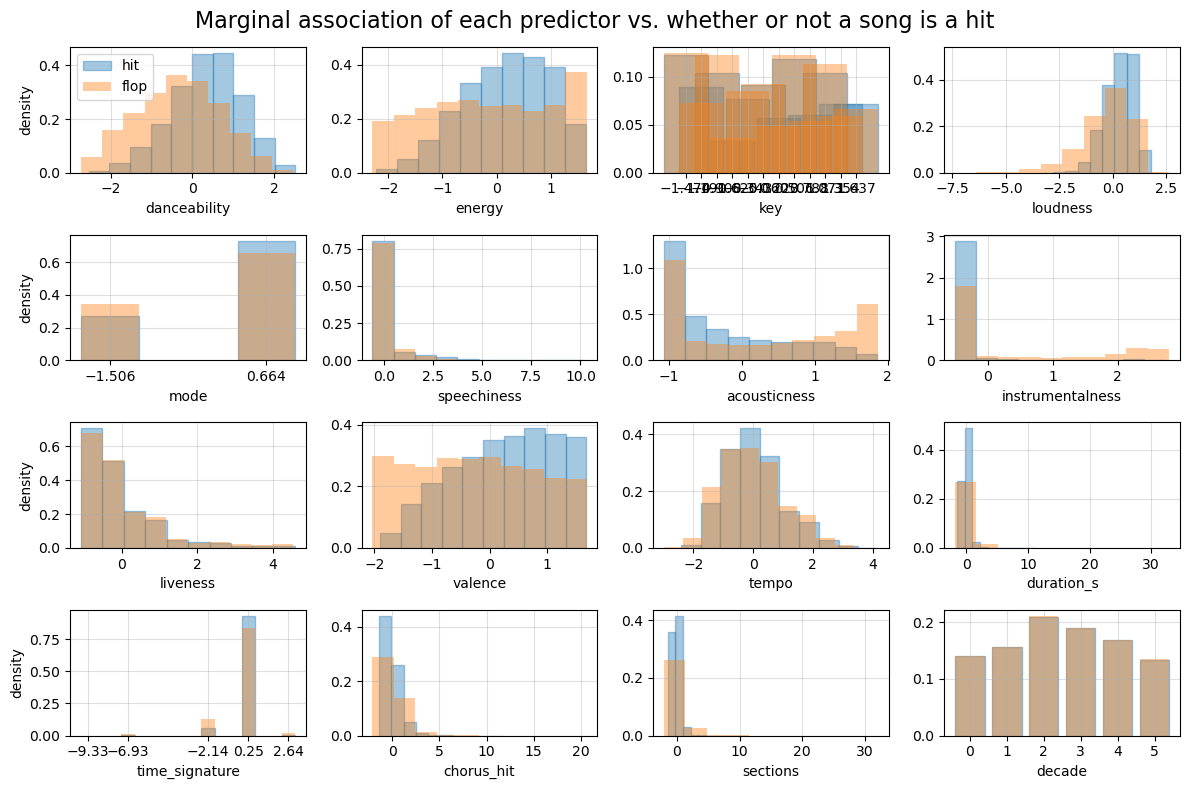

In [5]:
predictor_list = list(X_train.columns)
bool_array_hit = (y_train == 1)

# generate plot
hist_list = ['danceability', 'energy', 'loudness', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness',
             'valence', 'tempo', 'duration_s', 'chorus_hit', 'sections']

n_train = len(y_train)
n_hit_train = y_train.sum()
n_flop_train = n_train - n_hit_train

fig, axes = plt.subplots(4,4, sharey=False, figsize=(12,8))

plt.suptitle(
    "Marginal association of each predictor vs. whether or "
    "not a song is a hit",
    fontsize=16,
)

for i, (ax, predictor) in enumerate(zip(axes.flat, predictor_list)):
    # make subplot historgram if predictor is in hist_list
    if predictor in hist_list:
        ax.hist(
            X_train[predictor][bool_array_hit],
            density=True, edgecolor="tab:blue", alpha=0.4, label="hit"
        )
        ax.hist(
            X_train[predictor][~bool_array_hit],
            density=True, alpha=0.4, label="flop"
        )
    # otherwise plot as barplot
    else:
        # generate value counts for plotting (for both admitted and not admitted)
        pred_count_hit = X_train[predictor][bool_array_hit].value_counts().sort_index()
        pred_count_flop = X_train[predictor][~bool_array_hit].value_counts().sort_index()
        pred_vals_hit = pred_count_hit.index
        pred_vals_flop = pred_count_flop.index
        # when plotting bars divide by total n to convert counts to densities
        ax.bar(
            pred_vals_hit,
            pred_count_hit / n_hit_train,
            edgecolor="tab:blue", alpha=0.4, label="hit"
        )
        ax.bar(
            pred_vals_flop,
            pred_count_flop / n_flop_train,
            alpha=0.4, label="flop"
        )
        ax.set_xticks(pred_vals_flop)
    ax.set_xlabel(predictor)
    ax.set_ylabel("density" if i%4==0 else None)
    ax.grid(":", alpha=0.4)
    if i==0:
        ax.legend()
    
plt.tight_layout()

In [6]:
X_train.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,time_signature,chorus_hit,sections,decade,edm,latin,pop,r&b,rap,rock
12214,-1.726523,1.454546,-1.473704,0.552724,0.664164,0.513795,-1.043090,-0.507278,0.059378,-1.436572,...,0.248987,-0.575791,0.104426,3,0.0,0.0,0.0,0.0,0.0,1.0
4719,-1.026931,0.452440,-1.473704,0.280499,0.664164,-0.366729,-0.209745,-0.507278,-0.286799,1.089136,...,0.248987,-0.584802,0.711827,2,0.0,0.0,0.0,0.0,0.0,1.0
38622,0.857457,0.907943,-0.908156,0.809448,0.664164,-0.553330,-0.779680,-0.506956,-0.096401,1.437639,...,0.248987,0.599451,-0.300507,1,0.0,0.0,0.0,1.0,0.0,0.0
27704,0.648707,0.963395,-0.908156,0.035308,0.664164,-0.434372,-0.993479,-0.500806,-0.830296,0.841812,...,0.248987,0.506958,0.711827,5,0.0,0.0,0.0,1.0,0.0,0.0
27688,-0.096021,1.486233,-0.342607,1.040839,0.664164,-0.145140,-1.070081,-0.507215,-0.731636,0.493309,...,0.248987,0.187918,-0.907908,5,0.0,1.0,0.0,0.0,0.0,0.0


In [7]:
# Perform PCA on quantitative predictors for final EDA
pca = PCA().fit(X_train[quant_preds])
X_pca = pca.transform(X_train[quant_preds])

print(X_pca.shape)
print('\nExplained Variance Ratio:')
print(pca.explained_variance_ratio_.round(4).cumsum() * 100)


def getComponentContribution(c):
    comp = list(zip(X_train[quant_preds].columns, pca.components_[c].round(3)))
    print(f'\nComponent {c}:')
    print(list(filter(lambda x:x[1]>0, sorted(comp, key=lambda x:x[1], reverse=True))))
    
for c in range(3):
    getComponentContribution(c)

(32879, 15)

Explained Variance Ratio:
[20.55 33.68 42.74 50.6  57.84 64.8  71.01 77.08 82.89 88.35 93.22 96.09
 98.54 99.48 99.99]

Component 0:
[('acousticness', 0.419), ('instrumentalness', 0.29), ('sections', 0.102), ('duration_s', 0.091), ('chorus_hit', 0.025), ('mode', 0.003)]

Component 1:
[('duration_s', 0.668), ('sections', 0.648), ('energy', 0.154), ('instrumentalness', 0.085), ('loudness', 0.084), ('tempo', 0.069), ('time_signature', 0.059), ('speechiness', 0.052), ('liveness', 0.048), ('key', 0.045), ('chorus_hit', 0.032)]

Component 2:
[('danceability', 0.553), ('valence', 0.383), ('sections', 0.202), ('time_signature', 0.188), ('acousticness', 0.176), ('duration_s', 0.15), ('key', 0.031)]


(8219, 15)


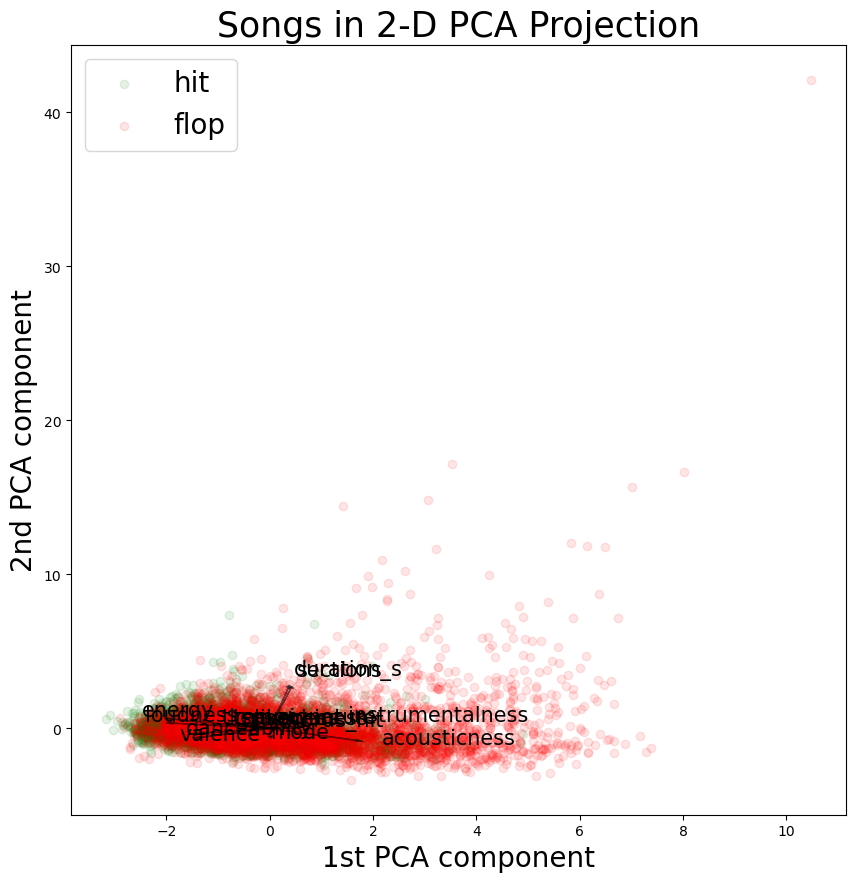

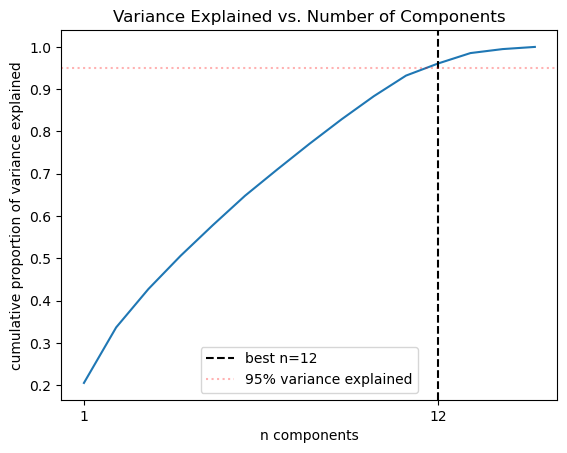

In [8]:
# Project songs onto first 2 PCA components and plot
plt.figure(figsize=(10,10))
passed = y_train[:len(y_train)//4] == 1
X_pca1 = X_pca[:(len(X_pca)//4)]
print(X_pca1.shape)
plt.scatter(X_pca1[passed,0], X_pca1[passed,1], c='green', alpha=0.1, label="hit")
plt.scatter(X_pca1[~passed,0], X_pca1[~passed,1], c='red', alpha=0.1, label="flop")

# scale up contributions by 2x for improved visibility
for i, vec in enumerate(pca.components_.T*4):
    plt.arrow(0, 0, vec[0], vec[1], color='k', head_width=0.1, alpha=0.5)
    offset = 1.3
    plt.annotate(X.columns[i],
                 (offset*vec[0], offset*vec[1]), color='k', fontsize=15)
plt.legend(fontsize=20)
plt.xlabel('1st PCA component', fontsize=20)
plt.ylabel('2nd PCA component', fontsize=20)
plt.title("Songs in 2-D PCA Projection", fontsize=25)
plt.show()

# Scree plot
n_thresh = np.argmax([np.cumsum(pca.explained_variance_ratio_) >= 0.95])+1
plt.plot(range(1, pca.n_components_+1), np.cumsum(pca.explained_variance_ratio_))
# plt.xlim(1)
plt.axvline(n_thresh, ls='--', c='k', label=f'best n={n_thresh}')
plt.axhline(0.95, ls=':', c='r', alpha=0.3, label=f'95% variance explained')
plt.xlabel("n components")
plt.ylabel("cumulative proportion of variance explained")
xticks = list(range(0, pca.n_components_+1, 50)) + [n_thresh]
xticks[0] = 1
plt.xticks(xticks);
plt.legend()
# plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.title("Variance Explained vs. Number of Components");

In [9]:
# HANDPICKED LOGIT MODEL
# Fit logistic regression model with predictors hand-picked from EDA: dancibility, loudness, valence, instrumentalness
hp_preds = ['danceability', 'loudness', 'valence', 'instrumentalness']
logit_hp = LogisticRegression().fit(X_train[hp_preds], y_train)


# QUANT PREDICTORS LOGIT MODEL
# Fit logistic regression model with all quantitative predictors, leaving out categorical variables 'track', 'artist', 'genre', and 'decade' 
logit_quant = LogisticRegression().fit(X_train[quant_preds], y_train)

# ALL PREDICTORS LOGIT MODEL
# Fit logistic regression models with all predictors, including 'genre' and 'decade'
all_preds = quant_preds + ['decade', 'edm', 'latin', 'pop', 'r&b', 'rap', 'rock']
logit_full = LogisticRegression().fit(X_train[all_preds], y_train)

# Calculate accuracy scores for both logistic regression models
logit_hp_train_acc = accuracy_score(y_train, logit_hp.predict(X_train[hp_preds]))
logit_hp_test_acc = accuracy_score(y_test, logit_hp.predict(X_test[hp_preds])) 
logit_quant_train_acc = accuracy_score(y_train, logit_quant.predict(X_train[quant_preds]))
logit_quant_test_acc = accuracy_score(y_test, logit_quant.predict(X_test[quant_preds]))
logit_full_train_acc = accuracy_score(y_train, logit_full.predict(X_train[all_preds]))
logit_full_test_acc = accuracy_score(y_test, logit_full.predict(X_test[all_preds]))

In [10]:
# Compile and display accuracy scores
all_acc = pd.DataFrame({'train_acc': [logit_hp_train_acc, logit_quant_train_acc, logit_full_train_acc], 
                        'test_acc': [logit_hp_test_acc, logit_quant_test_acc, logit_full_test_acc], 
                        'model': ['logit_hp', 'logit_quant', 'logit_full']})
all_acc.set_index('model', inplace=True)
display(all_acc)

# Display model intercepts and coefficients
print(
    "The intercept and coefficients for the 'logit_hp' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", np.array(logit_hp.intercept_).flatten()[0]
    )
)

for predictor, coef in zip(hp_preds, logit_hp.coef_.flatten()):
    print("\t{:<20}{:.4f}".format(predictor, coef))
    
print(
    "The intercept and coefficients for the 'logit_quant' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", np.array(logit_quant.intercept_).flatten()[0]
    )
)

for predictor, coef in zip(quant_preds, logit_quant.coef_.flatten()):
    print("\t{:<20}{:.4f}".format(predictor, coef))  
    
print(
    "The intercept and coefficients for the 'logit_full' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", np.array(logit_full.intercept_).flatten()[0]
    )
)

for predictor, coef in zip(all_preds, logit_full.coef_.flatten()):
    print("\t{:<20}{:.4f}".format(predictor, coef))  

,train_acc,test_acc
model,,
logit_hp,0.707807,0.716058
logit_quant,0.727516,0.732725
logit_full,0.733386,0.733820


The intercept and coefficients for the 'logit_hp' model are:

	intercept           -0.2051
	danceability        0.5884
	loudness            0.3930
	valence             0.0478
	instrumentalness    -1.0228
The intercept and coefficients for the 'logit_quant' model are:

	intercept           -0.2323
	danceability        0.5871
	energy              -0.5061
	key                 0.0392
	loudness            0.5755
	mode                0.1793
	speechiness         -0.2858
	acousticness        -0.4811
	instrumentalness    -1.0108
	liveness            -0.0305
	valence             0.0945
	tempo               0.0614
	duration_s          -0.0372
	time_signature      0.0580
	chorus_hit          -0.0435
	sections            -0.0656
The intercept and coefficients for the 'logit_full' model are:

	intercept           -0.1095
	danceability        0.5965
	energy              -0.4299
	key                 0.0403
	loudness            0.5630
	mode                0.1794
	speechiness         -0.6059
	acousticne

In [11]:
# BAGGING MODEL

# Create custom functions for performing cross-validation
# and for plotting the results

def calc_meanstd(X_train, y_train, depths, cv):
    """Performs cross-validation at varying tree depths
    
    This function fits decision tree classifiers at varying
    max tree-depths using cross-validation and provides lists
    training and mean and standard deviation validation scores
    for each specified tree depth.
    
    :param X_train: np.ndarray, 2-d array of training X values
    :param y_train: np.ndarray, 1-d array of training y values
    :param depth: list, depths at which to fit decision trees
    :param cv: int, number of folds at which to perform CV
    :returns: (list, list, list), a list of mean validation
              scores, a list of validation standard deviations,
              a list of train scores (based on models fit to the
              full training set)
    """
    cvmeans = []
    cvstds = []
    train_scores = []
    
    for depth in depths:
        clf = DecisionTreeClassifier(max_depth=depth)
        # calculate training score and save to list
        train_scores.append(clf.fit(X_train, y_train).score(X_train, y_train))
        # perform 5-fold CV and save mean and std to lists
        scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=cv)
        cvmeans.append(scores.mean())
        cvstds.append(scores.std())
        
    return cvmeans, cvstds, train_scores


def plot_cv_results(
    depths,
    cvmeans,
    cvstds,
    train_scores,
    title,
    limit_y=False,
    show_legend=True,
):
    """Generate plot of decision tree results at various depths
    
    Generates plot illustrating training and cross-validation
    accuracy score results for single decision tree classifiers
    fit at varying max depths. One line represents training
    scores and another line represents mean validation scores
    with +/-2 standard deviation bounds around those mean
    scores.
    
    :param depths: list, depths at which decision trees were fit
    :param cvmeans: np.ndarray, mean cross-validation scores at
                    each depth
    :param cvstd: np.ndarray, standard deviation cross-
                  validation scores at each depth 
    :param train_scores: np.ndarray, training scores (using the
                         full training set) at each depth
    :param title: str, plot title text
    :param limit_y: bool, whether to limit y-axis to just range
                    of validation means and +/-2 standard
                    deviations (default is False)
    :param show_legend: bool, whether to show legend on plot
                    (default=True)
    """
    plt.figure(figsize=(9, 4.5))
    plt.plot(
        depths,
        cvmeans,
        "^-",
        label="Mean validation",
        markeredgecolor="k",
        color="tab:orange",
        alpha=0.7,
        linewidth=2,
    )
    plt.fill_between(
        depths,
        cvmeans - 2*cvstds,
        cvmeans + 2*cvstds,
        color="tab:orange",
        alpha=0.3,
        label="Validation +/-2 standard deviations",
    )
    
    if limit_y:
        ylim = plt.ylim()
        plt.ylim(ylim)
    
    plt.plot(
        depths,
        train_scores,
        "o--",
        label="Training",
        color="tab:blue",
        alpha=0.4,
        linewidth=2,
    )

    if show_legend:
        plt.legend(fontsize=12)
    
    plt.ylabel("Accuracy", fontsize=12)
    plt.xlabel("Maximum tree depth", fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(depths)
    plt.grid(":", alpha=0.4)
    plt.tight_layout()

# set parameters for model fitting
depths = list(range(1, 26))
cv = 5

# perform CV and generate required results
cvmeans, cvstds, train_scores = calc_meanstd(
    X_train, y_train, depths, cv
)

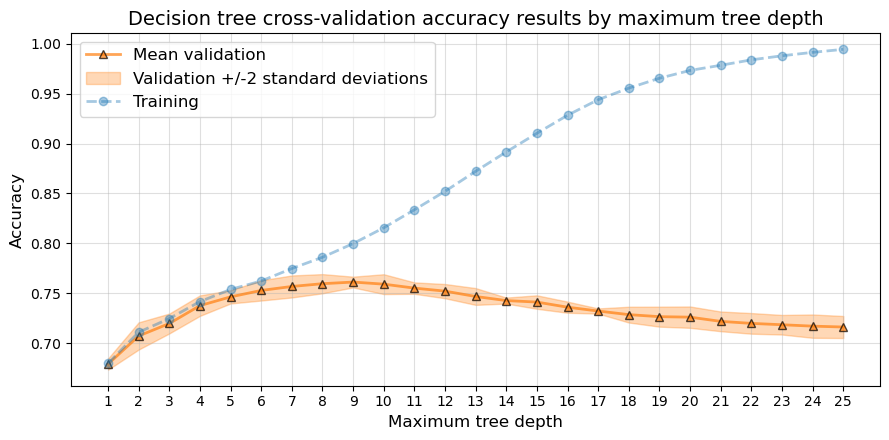

In [12]:
# convert results from lists to arrays for plotting function
cvmeans = np.array(cvmeans)
cvstds = np.array(cvstds)

# plot results as full plot
title = (
    "Decision tree cross-validation accuracy results by "
    "maximum tree depth"
)
plot_cv_results(
    depths,
    cvmeans,
    cvstds,
    train_scores,
    title,
    limit_y=False,
    show_legend=True,
)

In [13]:
# choose best depth after a qualitative assessment of our plots
best_cv_depth = 9

# BEGIN SOLUTION NO PROMPT
idx = depths.index(best_cv_depth)

# summarize CV results at best depth
print(
    "Cross-validated validation accuracy for our chosen best "
    "depth of {} is:\n\n\tmean    \t{:.4f}"
    "\n\t+/-2 stdev\t[{:.4f}, {:.4f}]\n".format(
        best_cv_depth,
        cvmeans[idx],
        cvmeans[idx] - 2*cvstds[idx],
        cvmeans[idx] + 2*cvstds[idx],
    )
)


# once depth is chosen (i.e. hyper-parameter is found),
# we re-fit the model with all training data
# SINGLE DECISION TREE MODEL 
fitted_tree = DecisionTreeClassifier(
    max_depth=best_cv_depth
).fit(X_train, y_train)

# END SOLUTION
best_cv_tree_train_score = fitted_tree.score(X_train, y_train) # SOLUTION
best_cv_tree_test_score = fitted_tree.score(X_test, y_test) # SOLUTION

# Add to results dataframe
all_acc.loc['fitted_tree, d=9'] = [best_cv_tree_train_score, best_cv_tree_test_score]

# set overfitting tree_depth based on provided rationale 
tree_depth = 20

Cross-validated validation accuracy for our chosen best depth of 9 is:

	mean    	0.7612
	+/-2 stdev	[0.7558, 0.7666]



In [14]:
display(all_acc)

,train_acc,test_acc
model,,
logit_hp,0.707807,0.716058
logit_quant,0.727516,0.732725
logit_full,0.733386,0.733820
"fitted_tree, d=9",0.799751,0.768613


In [15]:
n_trees = 55

# Fit optimal bagging model
fitted_bagging = BaggingClassifier(DecisionTreeClassifier(max_depth=tree_depth),
                                   n_estimators=n_trees).fit(X_train,y_train)

# evaluate results
bagging_train_score = fitted_bagging.score(X_train, y_train)
bagging_test_score = fitted_bagging.score(X_test, y_test)

# print results summary
print(
    "Bagging of depth-{} and {} trees achieves the "
    "following accuracy scores:\n\n\ttrain\t{:.4f}\n\tTEST\t{:.4f}"
    .format(
        tree_depth,
        n_trees,
        bagging_train_score,
        bagging_test_score,
    )
)

# Add to results dataframe
all_acc.loc['bagging'] = [bagging_train_score, bagging_test_score]

Bagging of depth-20 and 55 trees achieves the following accuracy scores:

	train	0.9789
	TEST	0.8019


In [16]:
display(all_acc)

,train_acc,test_acc
model,,
logit_hp,0.707807,0.716058
logit_quant,0.727516,0.732725
logit_full,0.733386,0.733820
"fitted_tree, d=9",0.799751,0.768613
bagging,0.978892,0.801946


In [17]:
# RANDOM FOREST MODEL

# fit random forest
fitted_rf = RandomForestClassifier(
    n_estimators=n_trees, max_features="sqrt", max_depth=tree_depth
).fit(X_train,y_train)

# evaluate results
random_forest_train_score = fitted_rf.score(X_train, y_train)
random_forest_test_score = fitted_rf.score(X_test, y_test)

# print results summary
print(
    "The random forest of depth-{} and {} trees achieves the "
    "following accuracy scores:\n\n\ttrain\t{:.4f}\n\tTEST\t{:.4f}"
    .format(
        tree_depth,
        n_trees,
        random_forest_train_score,
        random_forest_test_score,
    )
)

# Add to results dataframe
all_acc.loc['random_forest'] = [random_forest_train_score, random_forest_test_score]

The random forest of depth-20 and 55 trees achieves the following accuracy scores:

	train	0.9652
	TEST	0.7998


In [18]:
display(all_acc)

,train_acc,test_acc
model,,
logit_hp,0.707807,0.716058
logit_quant,0.727516,0.732725
logit_full,0.733386,0.733820
"fitted_tree, d=9",0.799751,0.768613
bagging,0.978892,0.801946
random_forest,0.965206,0.799757


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid

Best test accuracy: 774


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid

Best test accuracy: 672


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid

Best test accuracy: 700


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid

Best test accuracy: 394


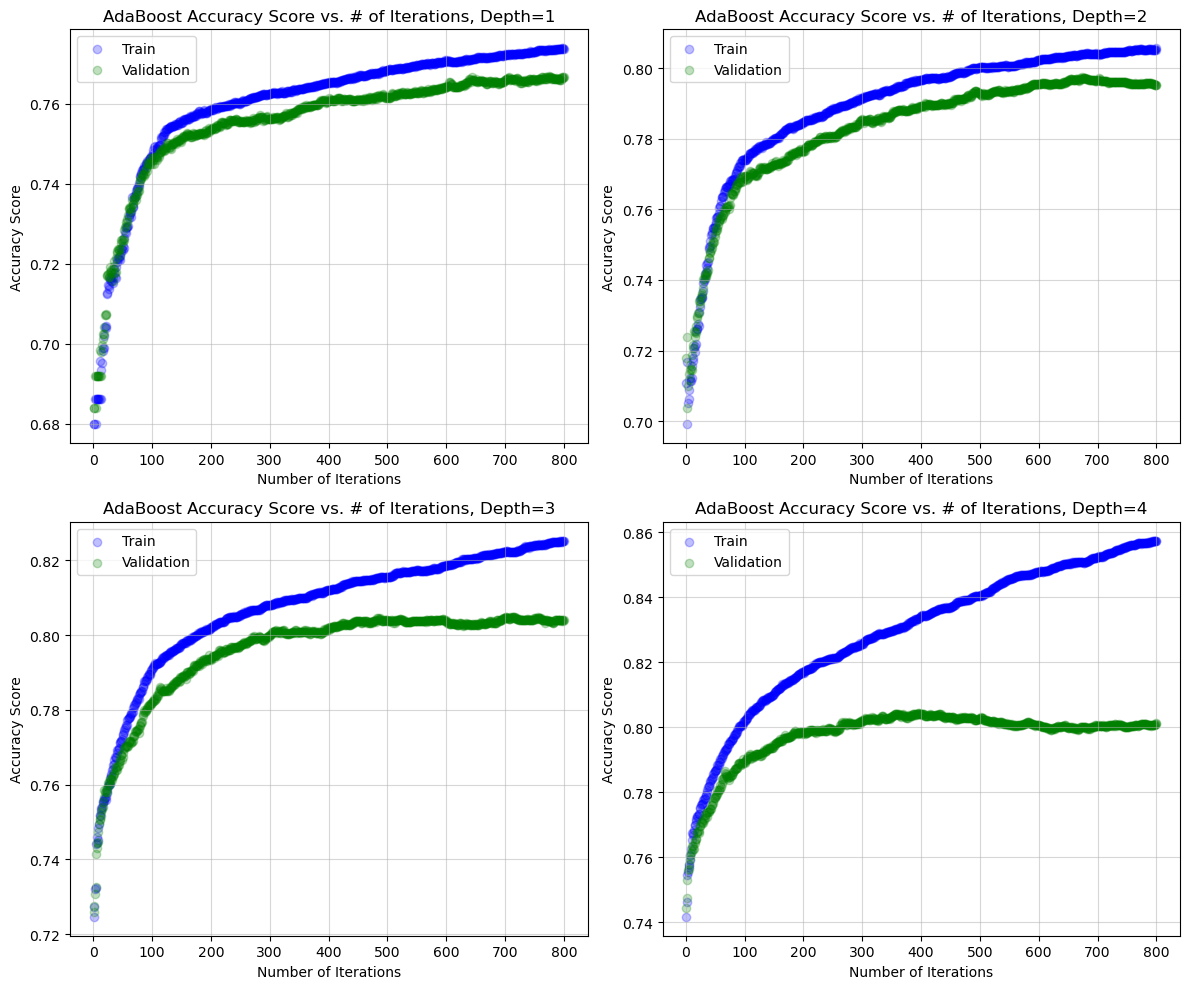

In [19]:
# ADABOOST MODEL
# Find optimal hyperparameters for AdaBoost model, iterating from depths 1-4 and 800 iterations for each depth
ds = [1, 2, 3, 4]

# Prepare for plotting
fig,axs = plt.subplots(2, 2, figsize=(12, 10))
axs=axs.ravel()

# Iterate
for d, ax in zip(ds, axs):
    # Fit AdaBoost classifier
    adaboost_temp = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=d),
                             n_estimators=800,
                             learning_rate=0.05).fit(X_train, y_train)
    # Plot train
    ax.scatter(range(1, 801), list(adaboost_temp.staged_score(X_train, y_train)), 
            c='b', alpha=0.25, label='Train')

    # Plot test
    ax.scatter(range(1, 801), list(adaboost_temp.staged_score(X_test, y_test)),
               c='g', alpha=0.25, label='Validation')
    ax.set_xlabel('Number of Iterations')
    ax.set_ylabel('Accuracy Score')
    ax.set_title(f'AdaBoost Accuracy Score vs. # of Iterations, Depth={d}')
    ax.grid(alpha=0.5)
    ax.legend()
    
    # Print index of best test score
    max_test_acc = max(list(adaboost_temp.staged_score(X_test, y_test)))
    print('Best test accuracy:', list(adaboost_temp.staged_score(X_test, y_test)).index(max_test_acc))

fig.tight_layout()

In [20]:
# Fit optimal AdaBoost model with max_depth=3, 700 iterations
adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                                   n_estimators=700,
                                   learning_rate=0.05).fit(X_train, y_train)
                                   
ada_train_acc = list(adaboost.staged_score(X_train, y_train))[-1]
ada_test_acc = list(adaboost.staged_score(X_test, y_test))[-1]

# Add to results df
all_acc.loc['adaboost'] = [ada_train_acc, ada_test_acc]

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


In [21]:
display(all_acc)

,train_acc,test_acc
model,,
logit_hp,0.707807,0.716058
logit_quant,0.727516,0.732725
logit_full,0.733386,0.733820
"fitted_tree, d=9",0.799751,0.768613
bagging,0.978892,0.801946
random_forest,0.965206,0.799757
adaboost,0.822288,0.804623


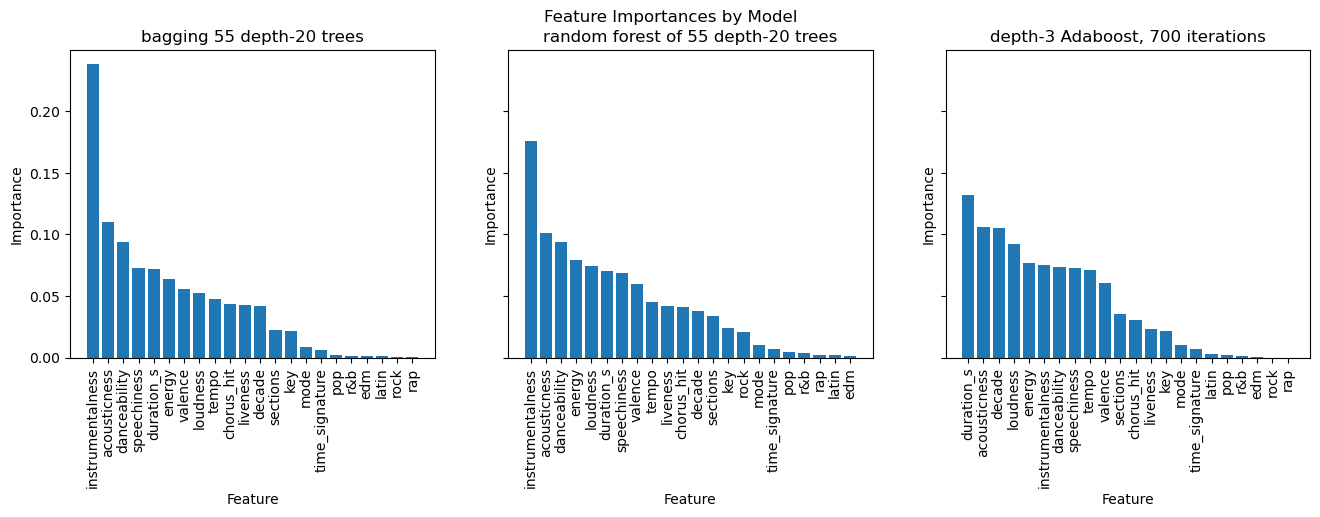

In [22]:
# Create a figure with 2 columns and 1 row
fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharey=True)

# calculate the average feature importances
# In bagging, each tree in the ensemble is trained on a bootstrapped sample of the data.
# Therefore, the feature importances for each tree may be different.
# However, you can calculate the average feature importance across all the trees
# in the ensemble to get a general idea of which features are the most important. 
importances = np.mean([tree.feature_importances_ for tree in fitted_bagging.estimators_], axis=0)

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Create a list of the feature names
feature_names = X_train.columns

# Create the first plot in the first column
ax[0].bar(range(X_train.shape[1]), importances[indices], align="center")
ax[0].set_xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
ax[0].set_xlabel("Feature")
ax[0].set_ylabel("Importance")
ax[0].set_title(f"bagging {n_trees} depth-{tree_depth} trees")

# Get the feature importances
importances = fitted_rf.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Create the second plot in the second column
ax[1].bar(range(X_train.shape[1]), importances[indices], align="center")
ax[1].set_xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
ax[1].set_xlabel("Feature")
ax[1].set_ylabel("Importance")
ax[1].set_title(f"random forest of {n_trees} depth-{tree_depth} trees")

# Get the feature importances
importances = adaboost.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Create the second plot in the second column
ax[2].bar(range(X_train.shape[1]), importances[indices], align="center")
ax[2].set_xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
ax[2].set_xlabel("Feature")
ax[2].set_ylabel("Importance")
ax[2].set_title(f"depth-3 Adaboost, 700 iterations")

plt.suptitle("Feature Importances by Model")

# Show the plot
plt.show()